## Hola soy un notebook de python de práctica

In [24]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as ppr
import seaborn as sns
import geopandas as gpd

In [3]:
## Leemos los datos seleccionados
df_main = pd.read_csv('../data/TB_HOSP_VAC_FALLECIDOS.csv')
df_oxigen = pd.read_csv('../data/Oxigeno_25-10-2021.csv', sep="|")
df_camas = pd.read_csv('../data/Camas-08_03_2022.csv', sep="|")

In [4]:
# Validar integridad del identificador único
len(df_main['id_persona'].unique()), df_main.shape[0]

(135958, 136422)

In [8]:
df_main['id_persona'].isna().sum()

0

In [5]:
## conteo de cuantas veces se duplica los id_persona
filtro_duplicados = df_main['id_persona'].duplicated(keep=False)
df_main[filtro_duplicados]['id_persona'].value_counts().head()

26422634    3
6054506     3
29048330    3
3820273     2
9985143     2
Name: id_persona, dtype: int64

In [10]:
# TODO: Crear variable si fue reinfeccion (0, 1)
# TODO: Crear variable si con el # de la reinfeccion (1, 2, 3, etc)

In [6]:
## Número de valores perdidos
edad_na_count = df_main['edad'].isna().sum()
print(edad_na_count)
print(round(edad_na_count / df_main.shape[0] * 100, 2), '%')

7843
5.75 %


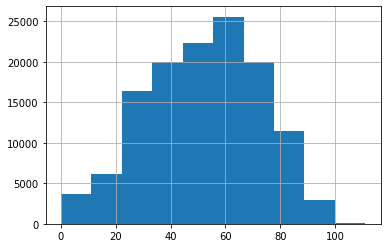

In [12]:
df_main['edad'].hist()
plt.show()

In [13]:
df_main["edad"].describe()

count    128579.000000
mean         52.179446
std          20.436026
min           0.000000
25%          37.000000
50%          54.000000
75%          68.000000
max         111.000000
Name: edad, dtype: float64

In [14]:
counts, bins = np.histogram(df_main["edad"].dropna().values,bins = 7)
bins

array([  0.        ,  15.85714286,  31.71428571,  47.57142857,
        63.42857143,  79.28571429,  95.14285714, 111.        ])

In [7]:
edad_bins = pd.cut(df_main["edad"], bins = [0,5,13,18,25,40,55,65,80,95,112])

edad_bins_counts = edad_bins.value_counts()

edad_bins_counts


(40, 55]     29595
(65, 80]     26201
(25, 40]     25404
(55, 65]     23376
(80, 95]      9954
(18, 25]      7492
(5, 13]       2197
(13, 18]      1938
(0, 5]        1926
(95, 112]      451
Name: edad, dtype: int64

In [8]:
df_main["edad_bins"] = edad_bins

In [9]:
df_main["sexo"].isna().sum() / df_main.shape[0]

0.05013854070457844

In [10]:
df_main["sexo"].value_counts(), df_main["sexo"].value_counts(normalize= True)

(M    69149
 F    60433
 Name: sexo, dtype: int64,
 M    0.533631
 F    0.466369
 Name: sexo, dtype: float64)

In [11]:
conteo_edad_x_sexo = (df_main[["edad_bins","sexo"]].dropna() ## selecion de columns y elimino NaNs
                    .groupby(["edad_bins","sexo"]).size() )# agrupo y cuento las obs. por intervalo de edad y sexo

conteo_edad_x_sexo


edad_bins  sexo
(0, 5]     F         850
           M        1076
(5, 13]    F         927
           M        1270
(13, 18]   F        1310
           M         628
(18, 25]   F        5866
           M        1597
(25, 40]   F       15891
           M        9303
(40, 55]   F       11255
           M       18232
(55, 65]   F        8820
           M       14509
(65, 80]   F       10327
           M       15849
(80, 95]   F        4383
           M        5567
(95, 112]  F         242
           M         209
dtype: int64

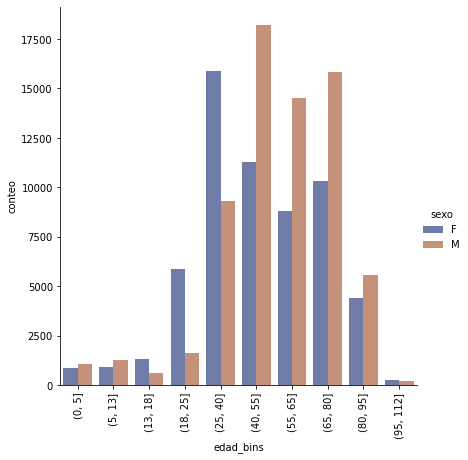

In [20]:
## gráfica de barras de cantidad de personas por intervalo de edad por género

g = sns.catplot(
    data=conteo_edad_x_sexo.reset_index().rename(columns={0: "conteo"}),
     kind="bar",
    x="edad_bins", y="conteo", hue="sexo",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.set_xticklabels(rotation = 90)

In [12]:
geo_vars = ['ubigeo_inei_domicilio', 'dep_domicilio', 'prov_domicilio',
       'dist_domicilio']
df_main[geo_vars].isna().sum()

ubigeo_inei_domicilio    0
dep_domicilio            0
prov_domicilio           0
dist_domicilio           0
dtype: int64

In [13]:
df_main['ubigeo_inei_domicilio'] = df_main['ubigeo_inei_domicilio'].astype(str)

In [14]:
df_main[geo_vars].dtypes

ubigeo_inei_domicilio    object
dep_domicilio            object
prov_domicilio           object
dist_domicilio           object
dtype: object

In [15]:
df_main[geo_vars].describe()

,ubigeo_inei_domicilio,dep_domicilio,prov_domicilio,dist_domicilio
count,136422,136422,136422,136422
unique,1716,25,196,1580
top,150142,LIMA,LIMA,VILLA EL SALVADOR
freq,7156,50719,46309,7156


**Manejando datos geoespaciales**

In [16]:
gdf_deps = gpd.read_file('../data/departamentos/DEPARTAMENTOS.shp')

<AxesSubplot:>

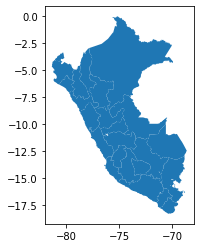

In [26]:
## creando un plot del mapa
gdf_deps.plot()

In [18]:
gdf_deps.columns

Index(['IDDPTO', 'DEPARTAMEN', 'CAPITAL', 'FUENTE', 'geometry'], dtype='object')

In [19]:
## analizando si tienen la misma llave mi base de datos y el del shapefile
df_unique_dep = df_main['dep_domicilio'].unique()
df_unique_dep.sort()

gdf_unique_dep = gdf_deps['DEPARTAMEN'].unique()
gdf_unique_dep.sort()

# VALIDAMOS QUE LOS NOMBRES DE DEPARTAMENTOS
# EN LOS DOS DATASETS SEAN IGUALES
(df_unique_dep == gdf_unique_dep).all() # True

True

In [20]:
# Contamos la cantidad de hospitalizados por departamento
conteo_x_dept = df_main['dep_domicilio'].value_counts()
conteo_x_dept = conteo_x_dept.reset_index()
conteo_x_dept.head()

,index,dep_domicilio
0,LIMA,50719
1,ANCASH,11753
2,CUSCO,10952
3,CAJAMARCA,8584
4,PIURA,7909


In [21]:
# Unimos los conteos utilizando los nombres de departamentos
gdf_conteo_x_dept = pd.merge(left=gdf_deps, right=conteo_x_dept, 
                             left_on="DEPARTAMEN", right_on='index')

In [22]:
gdf_conteo_x_dept.head()

,IDDPTO,DEPARTAMEN,CAPITAL,FUENTE,geometry,index,dep_domicilio
0,01,AMAZONAS,CHACHAPOYAS,INEI,"POLYGON ((-77.81211 -2.98962, -77.81332 -2.990...",AMAZONAS,1833
1,02,ANCASH,HUARAZ,INEI,"POLYGON ((-77.64692 -8.05086, -77.64669 -8.052...",ANCASH,11753
2,03,APURIMAC,ABANCAY,INEI,"POLYGON ((-73.74632 -13.17456, -73.74570 -13.1...",APURIMAC,2778
3,04,AREQUIPA,AREQUIPA,INEI,"POLYGON ((-71.98109 -14.64062, -71.98093 -14.6...",AREQUIPA,490
4,05,AYACUCHO,AYACUCHO,INEI,"POLYGON ((-74.34843 -12.17503, -74.35000 -12.1...",AYACUCHO,627


<AxesSubplot:>

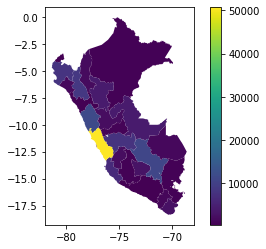

In [25]:
# Mapa de calor de # de hospitalizados x departamento
gdf_conteo_x_dept.plot("dep_domicilio", cmap='viridis',
                       legend=True)

## Correlación

Es el valor numérico que describle la relación ( directa o inversa) entre dos variables, pero solo la forma **lineal**. Es decir, un correlación no indica que no existe relación entre las variables, sino que no presenta una relación lineal.

In [39]:
np.corrcoef(df_main["eess_renaes"],df_main["flag_uci"])

array([[1.        , 0.02111353],
       [0.02111353, 1.        ]])

In [27]:
df_main.corr()

,eess_renaes,id_eess,id_persona,edad,flag_uci,con_oxigeno,con_ventilacion,flag_vacuna,cdc_positividad,cdc_fallecido_covid
eess_renaes,1.000000,0.999724,0.019344,-0.115995,0.021114,-0.172506,0.049255,-0.008720,-0.189981,-0.078807
id_eess,0.999724,1.000000,0.020345,-0.115638,0.021211,-0.170655,0.050076,-0.009522,-0.189911,-0.077915
id_persona,0.019344,0.020345,1.000000,-0.115043,0.009564,-0.093752,0.003587,-0.465574,-0.126850,0.307252
edad,-0.115995,-0.115638,-0.115043,1.000000,0.031786,0.413115,0.023437,-0.126770,0.121101,0.418936
flag_uci,0.021114,0.021211,0.009564,0.031786,1.000000,0.166862,0.747212,-0.077172,0.042261,0.103393
con_oxigeno,-0.172506,-0.170655,-0.093752,0.413115,0.166862,1.000000,0.167074,-0.045013,0.193051,0.286102
con_ventilacion,0.049255,0.050076,0.003587,0.023437,0.747212,0.167074,1.000000,-0.083547,0.052755,0.136440
flag_vacuna,-0.008720,-0.009522,-0.465574,-0.126770,-0.077172,-0.045013,-0.083547,1.000000,0.095966,-0.658336
cdc_positividad,-0.189981,-0.189911,-0.126850,0.121101,0.042261,0.193051,0.052755,0.095966,1.000000,0.091382
cdc_fallecido_covid,-0.078807,-0.077915,0.307252,0.418936,0.103393,0.286102,0.136440,-0.658336,0.091382,1.000000


In [ ]:
#construir variable tiempo de hospitalización por covid

df_main["fecha_ingreso_hosp"] = pd.to_datetime(df_main["fecha_ingreso_hosp"],format= "%d/%m/%Y")
df_main[]

In [42]:
df_main["fecha_ingreso_hosp"]

0          1/09/2020
1         24/02/2021
2         14/06/2020
3         28/05/2020
4          6/10/2020
             ...    
136417     9/02/2021
136418     1/07/2021
136419     8/08/2020
136420     2/04/2021
136421     2/03/2021
Name: fecha_ingreso_hosp, Length: 136422, dtype: object

# PRPEARACIÓN ANTES DEL EDA
## 1. selecionar las variables a analizar que sean relevantes para el estudio
## 2. Verificar la integridad de las variables ( si estan limpias o que debemos hacer para limpiarlo)
## 3. plantearse preguntas de exploración
## 4. planterar hipotesis a partir de nnuestras variables
# EDA
## 5. limpiar los datos (80%)
## 6. Responder las preguntas de exploración a partir de los datos ( indicadores y gráficas)
## 7. responder las impotesis ( test estadísticos | estadisitica descriptiva)
## 8. Generar un reporte para el público en general.

#### PREPARACIÓN ANTES DEL EDA

1. selecionar las variables a analizar que sean relevantes para el estudio
2. Verificar la integridad de las variables ( si estan limpias o que debemos hacer para limpiarlo)
3. plantearse preguntas de exploración
4. planterar hipotesis a partir de nnuestras variables

#### EDA

5. limpiar los datos (80%)
6. Responder las preguntas de exploración a partir de los datos ( indicadores y gráficas)
7. responder las impotesis ( test estadísticos | estadisitica descriptiva)
8. Generar un reporte para el público en general.